week10 objectives:

1. extend emotion set to include arousal, valence and dominance
2. extract glove embeddings for bignews

In [1]:
import os
from tqdm import tqdm

import numpy as np


BASE_PATH = '/'.join(os.getcwd().split('/')[ : -2])

DATA_PATH = "gallina/bignews"

In [2]:
# vast dataset
'''
import csv

f = open("data/train.csv", newline="")
reader = csv.reader(f, delimiter=',')
    
header = next(reader)
print(header[1 : ])

keys = {"post": 1, "ori_topic": 2, "new_topic": 4, "label": 5, "topic": 13, "contains_topic": 15}

rows = []

for row in reader:
        i = {}  # instance
        for k in keys.keys():
            i[k] = row[keys[k]]  # reverse mapping
        rows.append(i)

print(f"number of samples: {len(rows)}")
'''

'\nimport csv\n\nf = open("data/train.csv", newline="")\nreader = csv.reader(f, delimiter=\',\')\n    \nheader = next(reader)\nprint(header[1 : ])\n\nkeys = {"post": 1, "ori_topic": 2, "new_topic": 4, "label": 5, "topic": 13, "contains_topic": 15}\n\nrows = []\n\nfor row in reader:\n        i = {}  # instance\n        for k in keys.keys():\n            i[k] = row[keys[k]]  # reverse mapping\n        rows.append(i)\n\nprint(f"number of samples: {len(rows)}")\n'

In [3]:
import json


data, f_names = [], ["train_center", "train_left", "train_right"]

for f_name in f_names:
    with open(os.path.join(BASE_PATH, DATA_PATH, f"{f_name}.json")) as f:

        X = json.load(f)
        '''
        for i, x in enumerate(X):
            x['label'] = f_name.split('_')[-1]
            X[i] = x
        '''
    data.append(X)


In [4]:
print(f"center: {len(data[0])}, left: {len(data[1])}, right: {len(data[2])}")

center: 772194, left: 779499, right: 779859


In [5]:
data[0][0]

{'title': 'After past rejections, medical cannabis OK’d for opioid addicts',
 'date': '2019-03-30',
 'url': 'https://apnews.com/8134a7887fbf46d4bcb8983fe31cad3a',
 'source': 'ap',
 'html': ['/data/yujian/data/online_news/ap/html/202007-202008.json', 17699],
 'text': ['The State Medical Cannabis Advisory Board twice in recent years voted to recommend opioid use disorder as a qualifying condition for the state’s medical marijuana program — only to have former Gov. Susana Martinez’s health secretary reject the proposal.',
  'The board on Friday approved a third recommendation in favor of including opioid addiction for the program. And this time, there was a sense that under Gov. Michelle Lujan Grisham — a former state Department of Health secretary who helped create the medical marijuana program — the result would be different.',
  'Within hours of the board’s decision, the new Health Department Secretary, Kathy Kunkel, said she’d accept its recommendation.',
  '“Using medical cannabis is

feature extraction

In [2]:
import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kxs1207/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
text = "Mary and Samantha arrived at the bus station early but waited until noon for the bus"

def word_extraction(sentence):    
    ignore = stopwords.words('english')   
    words = re.sub("[^\w]", " ",  sentence).split()    
    
    cleaned_text = [w.lower() for w in words if w not in ignore]    
    
    return cleaned_text


words = word_extraction(text)

print(words)

['mary', 'samantha', 'arrived', 'bus', 'station', 'early', 'waited', 'noon', 'bus']


In [6]:
import torchtext

glove = torchtext.vocab.GloVe(name='840B', dim=300)  # size = 300


.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                               
100%|█████████▉| 2196016/2196017 [03:58<00:00, 9211.52it/s]


In [9]:
import pickle

size = 300
sample_size = 100000


# tokenize
for X, f_name in zip(data, f_names):
    x = []

    for i in tqdm(X[ : sample_size], desc=f"{f_name.split('_')[-1]}"):
        embedding = []
        
        for text in i['text']:
            text_embedding = np.zeros(size).reshape((1, size))
            count = 0

            for word in word_extraction(text):
                word_embedding = glove[word].numpy().reshape(1, -1)
                
                # check
                if not np.all(word_embedding == 0):
                    text_embedding += word_embedding
                    count += 1      
            
            # check for zero
            if np.all(text_embedding):
                text_embedding /= count
                
                embedding.append(text_embedding.tolist()[0])

        x.append(embedding)
    
    with open(f"feature/{f_name.split('_')[-1]}.p", 'wb') as f:
        pickle.dump(x, f)


right: 100%|██████████| 100000/100000 [29:07<00:00, 57.22it/s] 


main: extract features with bag of words and bert separately, concatenate comment and target features to form a feature set

week11 objectives:

1. train a baseline on glove_300
2. compare performance with fast_text embedding

In [4]:
import pickle


size = 300

data, f_names = [], ["train_center", "train_left", "train_right"]
labels = []

label = {"right": 0, "center": 1, "left": 2}


# load data
for f_name in f_names:
    with open(f"feature/{f_name.split('_')[-1]}.p", 'rb') as f:
        X = pickle.load(f)

        for x in tqdm(X, total=len(X)):
            embedding = np.zeros(size).reshape((1, size))

            for text_embedding in x:
                embedding += np.array(text_embedding).reshape(1, -1)
            # mean
            data.append(embedding[0].tolist())
            # reverse
            labels.append(label[f_name.split('_')[-1]])


100%|██████████| 100000/100000 [00:48<00:00, 2060.42it/s]


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV


x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [6]:
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


In [7]:
import warnings
warnings.filterwarnings('ignore')


steps = [
    # ('pca', PCA()),
    ('clf', LogisticRegression())
    ]
        
pipe = Pipeline(steps)


In [8]:
params = {
    # 'pca__n_components' : [80, 100, 120, 140],
    'clf__penalty' : ['l1', 'l2', 'elasticnet'],
    'clf__max_iter' : [300, 400, 500]
}

gs = GridSearchCV(estimator=pipe, param_grid=params, scoring='accuracy', verbose=1)

gs.fit(x_train, y_train)

print(f"best params: {gs.best_params_}")


from sklearn.metrics import accuracy_score

y_pred = gs.predict(x_test)
acc = accuracy_score(y_test, y_pred)

print(f"test accuracy: {acc}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
best params: {'clf__max_iter': 500, 'clf__penalty': 'l2'}
test accuracy: 0.5709898989898989


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


steps = [
    # ('pca', PCA()),
    ('clf', GradientBoostingRegressor())
    ]
        
pipe = Pipeline(steps)

params = {
    'clf__learning_rate': [0.01, 0.02, 0.03, 0.04],
    'clf__subsample'    : [0.9, 0.5, 0.2, 0.1],
    'clf__n_estimators' : [100, 500, 1000, 1500],
    'clf__max_depth'    : [4, 6, 8, 10]
}

gs = GridSearchCV(estimator=pipe, param_grid=params, cv=2, scoring='accuracy', verbose=1)

gs.fit(x_train, y_train)

print(f"best params: {gs.best_params_}")


from sklearn.metrics import accuracy_score

y_pred = gs.predict(x_test)
acc = accuracy_score(y_test, y_pred)

print(f"test accuracy: {acc}")


In [11]:
label = {"right": 0, "center": 1, "left": 2}


list(label.values())

[0, 1, 2]

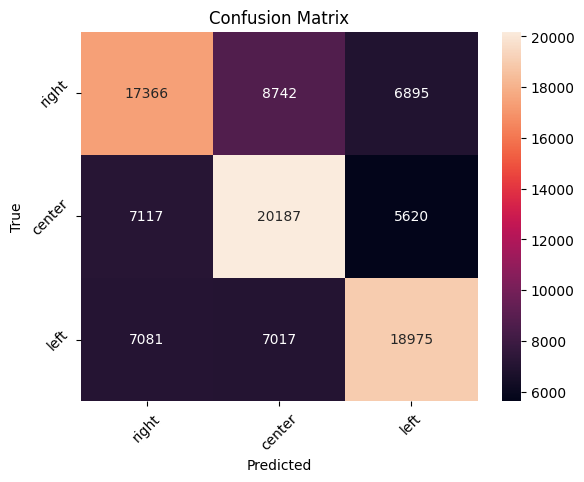

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report


ax= plt.subplot()

predictions = gs.predict(x_test)
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); 

ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(list(label.keys()), rotation=45); ax.yaxis.set_ticklabels(list(label.keys()), rotation=45);

In [15]:
print("---- test accuracy %s ----" % round(accuracy_score(y_test, predictions), 4))

---- test accuracy 0.571 ----


In [16]:
print(classification_report(y_test, predictions, target_names=list(label.keys())))

              precision    recall  f1-score   support

       right       0.55      0.53      0.54     33003
      center       0.56      0.61      0.59     32924
        left       0.60      0.57      0.59     33073

    accuracy                           0.57     99000
   macro avg       0.57      0.57      0.57     99000
weighted avg       0.57      0.57      0.57     99000



In [14]:
import pickle

with open("lr.p", 'wb') as f:
    pickle.dump(gs, f)